# `modtox.FeatureSelector` 
Here, we will evaluate how different feature selection techniques affect the performance of the model. We will use the dataset with the best parameter combination (in terms of accuracy). 

There are two implemented ways to reduce the number of features:
- __PCA :__ reduces dimensionality by projecting in a lower-dimension plane.
- __RFECV :__ stepwise removal of features and evaluation.

In [1]:
import pandas as pd
import os

from modtox.modtox.ML.dataset import DataSet

target = "3ai8"
csv = os.path.join(os.path.abspath(""), "data", target, "mordred_topo_morgan.csv")
df = pd.read_csv(csv, index_col=0)
ds = DataSet(df)

import warnings
warnings.filterwarnings('ignore')  # Ignore pandas warnings in output (copy/slice)
dfs = ds.transform(outliers_threshold=0, resampling_method="none", scaling_method="normalize")

X_train, y_train = dfs["X_train"], dfs["y_train"]
X_test, y_test = dfs["X_test"], dfs["y_test"]

## Evaluation methodology
The performance of each selection will evaluated with an untuned VotingClassifier and compared to the non-reduced scores.

In [2]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, matthews_corrcoef

In [3]:
def score(X_train, y_train, X_test, y_test):
    clf = VotingClassifier(estimators=[
        ("knn", KNeighborsClassifier()),
        ("lr", LogisticRegression()),
        ("svc", SVC()),
        ("tree", DecisionTreeClassifier()),
        ("nb", BernoulliNB())
    ])
    
    fitted_clf = clf.fit(X_train, y_train)
    y_pred_train = fitted_clf.predict(X_train)
    ref_acc_train = accuracy_score(y_train, y_pred_train)
    ref_matt_train = matthews_corrcoef(y_train, y_pred_train)

    y_pred_test = fitted_clf.predict(X_test)
    ref_acc_test = accuracy_score(y_test, y_pred_test)
    ref_matt_test = matthews_corrcoef(y_test, y_pred_test)
    
    scores = [ref_acc_train, ref_acc_test, ref_matt_train, ref_matt_test]
    df = pd.DataFrame([scores], columns=[
        "Train accuracy", 
        "Test accuracy", 
        "Train MattCorrCoef",
        "Test MattCorrCoef",
    ])
    return df

In [4]:
ref_scores = score(X_train, y_train, X_test, y_test)
ref_scores

,Train accuracy,Test accuracy,Train MattCorrCoef,Test MattCorrCoef
0,0.960432,0.834532,0.913588,0.626898


## PCA
PCA allows us to determine the number of features or the percentage of explained variance we want to keep. In this case, we will keep 95% of the model's explained variance.

In [5]:
from modtox.modtox.ML.selector import _PCA

In [6]:
var = 0.95
pca = _PCA(variance=var)
fitted_sel = pca.fit_selector(X_train)

We can easily plot the explained variance vs feature number:

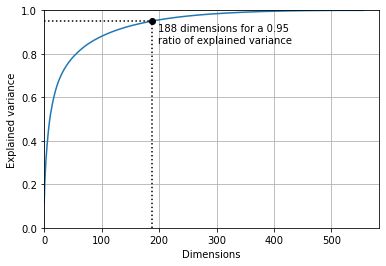

In [7]:
import matplotlib.pyplot as plt
import numpy as np

x, y = pca.plotting_data()
plt.plot(x, y)
plt.xlabel("Dimensions")
plt.ylabel("Explained variance")
plt.ylim(0, 1)
plt.xlim(0)
plt.grid()
d = np.argmax(y >= var) + 1
plt.plot([d, d], [0, var], "k:")
plt.plot([0, d], [var, var], "k:")
plt.plot(d, var, "ko")
plt.text(x=d+10, y=var-0.1, s=f"{d} dimensions for a 0.95\nratio of explained variance")
plt.savefig(f"data/{target}/PCA.png")

To compare the initial model to reduced model:

In [8]:
X_train_reduced = fitted_sel.transform(X_train) 
X_test_reduced = fitted_sel.transform(X_test)
pca_scores = score(X_train_reduced, y_train, X_test_reduced, y_test)
pca_scores

,Train accuracy,Test accuracy,Train MattCorrCoef,Test MattCorrCoef
0,0.940647,0.791367,0.868272,0.525619


The model has not improved, but it has been simplified. Fitting the model is now much faster.

## RFECV

In [9]:
from sklearn.feature_selection import RFECV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, matthews_corrcoef

In [10]:
step = 10
sel = RFECV(estimator=SVC(kernel="linear"), cv=2, step=10, scoring="accuracy", min_features_to_select=1)
sel.fit(X_train, y_train)
sel.grid_scores_

array([0.64928058, 0.65467626, 0.70143885, 0.75539568, 0.75899281,
       0.73741007, 0.73021583, 0.75      , 0.74820144, 0.76798561,
       0.76438849, 0.76438849, 0.77697842, 0.79496403, 0.78597122,
       0.80035971, 0.8057554 , 0.80395683, 0.79676259, 0.80035971,
       0.80035971, 0.80035971, 0.80035971, 0.79496403, 0.78956835,
       0.79496403, 0.79676259, 0.79136691, 0.79316547, 0.7823741 ,
       0.78597122, 0.78956835, 0.78776978, 0.7823741 , 0.78956835,
       0.79136691, 0.78956835, 0.79496403, 0.78597122, 0.78417266,
       0.78597122, 0.78417266, 0.78776978, 0.79136691, 0.78597122,
       0.78597122, 0.78597122, 0.78776978, 0.78597122, 0.78417266,
       0.7823741 , 0.78776978, 0.79136691, 0.79496403, 0.79316547,
       0.78956835, 0.79316547, 0.79316547, 0.79496403, 0.79496403,
       0.78956835, 0.78776978, 0.78597122, 0.79496403, 0.79496403,
       0.79676259, 0.80035971, 0.80035971, 0.79856115, 0.79856115,
       0.79856115, 0.79496403, 0.79676259, 0.80035971, 0.79676

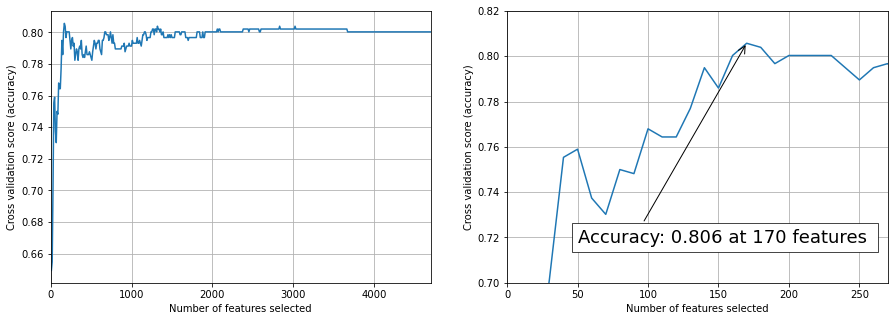

In [66]:
import numpy as np
import matplotlib.pyplot as plt
y = sel.grid_scores_
x = [x*10 for x in list(range(1, len(y) + 1))]
xmax = x[np.argmax(y)]
ymax = y.max()

fig, axs = plt.subplots(1, 2, figsize=(15,5))
axs[0].set_xlabel("Number of features selected")
axs[0].set_xlim(0, len(x*10))
axs[0].set_ylabel("Cross validation score (accuracy)")
axs[0].grid()
axs[0].plot(x, y)

axs[1].set_xlabel("Number of features selected")
axs[1].set_xlim(0, xmax+100)
axs[1].set_ylim(0.7, 0.82)
axs[1].set_ylabel("Cross validation score (accuracy)")
axs[1].plot(x, y)

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
arrowprops = dict(
    arrowstyle="->", connectionstyle="angle,angleA=0,angleB=60"
)
kw = dict(
    xycoords="data",
    textcoords="axes fraction",
    arrowprops=arrowprops,
    bbox=bbox_props,
    ha="right",
    va="top",
    fontsize="18"
)
text = f"Accuracy: {ymax:.3f} at {xmax} features "
plt.annotate(text, xy=(xmax, ymax), xytext=(0.96, 0.2), **kw)
plt.grid()
plt.savefig(f"data/{target}/RFECV.png")

In [12]:
import pickle5
with open(f"data/{target}/fitted_RFECV_step{step}.pickle", "wb") as f:
    pickle5.dump(sel, f)

In [59]:
with open(f"data/{target}/fitted_RFECV_step{step}.pickle", "rb") as f:
    sel = pickle5.load(f)

In [48]:
mask = sel.get_support()
selected_features = [col for i, col in enumerate(X_train.columns) if mask[i] == True]
count = dict()

for ft in ["topo", "morgan", "mordred"]:
    count[ft] = sum([True for col in selected_features if col.startswith(ft)])

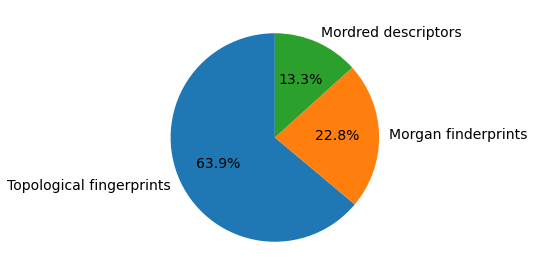

In [49]:
values = list(count.values())
labels = ["Topological fingerprints", "Morgan finderprints", "Mordred descriptors"]
plt.pie(values, labels=labels, startangle=90, autopct='%1.1f%%', textprops={'fontsize': 14})
plt.tight_layout()
plt.savefig(f"data/{target}/selected_features.png")

In [15]:
X_train_reduced = sel.transform(X_train) 
X_test_reduced = sel.transform(X_test)
rfecv_scores = score(X_train_reduced, y_train, X_test_reduced, y_test)
rfecv_scores

,Train accuracy,Test accuracy,Train MattCorrCoef,Test MattCorrCoef
0,0.969424,0.827338,0.932468,0.607838


## Method comparsion

In [16]:
sc = ref_scores.append(pca_scores)
sc = sc.append(rfecv_scores)
sc["method"] = ["none", "PCA", "RFECV"]
sc.to_csv(f"data/{target}/dim_red.csv")
sc

,Train accuracy,Test accuracy,Train MattCorrCoef,Test MattCorrCoef,method
0,0.960432,0.834532,0.913588,0.626898,none
0,0.940647,0.791367,0.868272,0.525619,PCA
0,0.969424,0.827338,0.932468,0.607838,RFECV


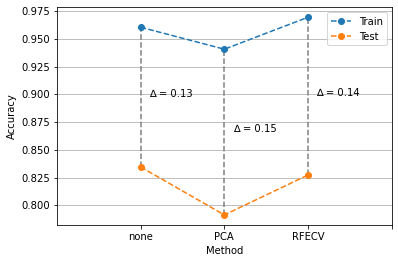

In [17]:
acc = sc[["method", "Train accuracy", "Test accuracy"]]
ax = acc.plot(
    x="method", 
    marker="o", 
    linestyle="--", 
    xlim=(-1, 3), 
    xticks=[0, 1, 2, 3, 4], 
    xlabel="Method", 
    ylabel="Accuracy"
)
ax.legend(["Train", "Test"])
ax.grid(axis="y")
for i, met in enumerate(["none", "PCA", "RFECV"]):
    test = sc[sc["method"] == met]["Test accuracy"]
    train = sc[sc["method"] == met]["Train accuracy"]
    diff = float(train-test)
    ax.vlines(x=i, ymin=test, ymax=train, color="gray", linestyle="--")
    ax.text(x=i+0.1, y=test + diff/2, s=f"∆ = {diff:.2f}")
plt.savefig(f"data/{target}/dim_red.png")